In [85]:
pip install livelossplot

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

from livelossplot import PlotLossesKeras

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from os import listdir
from os.path import isfile, isdir, join

In [87]:
img_width = 128
img_height = 128

train_dir = 'C:\\Users\hp\\OneDrive\\Desktop\\archive\\train'
test_dir = 'C:\\Users\hp\\OneDrive\\Desktop\\archive\\test'

EPOCHS = 20
BATCH_SIZE = 32

INPUT_SHAPE = (img_width, img_height)

In [88]:
data_generator = ImageDataGenerator(
    rescale=1/255.,
    vertical_flip=True,
    horizontal_flip=True,
    rotation_range=90,
    height_shift_range=0.3,
    width_shift_range=0.5,
    brightness_range=[0.1,0.9],
    validation_split=0.2
)

In [89]:
classes =sorted(listdir(train_dir))
classes

['Dark', 'Green', 'Light', 'Medium']

In [90]:
train_gen = data_generator.flow_from_directory(
    train_dir,
    target_size=INPUT_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes,
    subset='training',
    shuffle=True,
    seed=42
)

validation_gen = data_generator.flow_from_directory(
    test_dir,
    target_size=INPUT_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes,
    subset='training',
    shuffle=True,
    seed=42
)

Found 960 images belonging to 4 classes.
Found 320 images belonging to 4 classes.


In [91]:
model = Sequential()

#### Input Layer ####
model.add(
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(128,128,3))
)

#### Convolutional Layers ####
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(512, (5,5), activation='relu', padding='same'))
model.add(Conv2D(512, (5,5), activation='relu'))
model.add(MaxPooling2D((4,4)))
model.add(Dropout(0.2))

#### Fully-Connected Layer ####
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(classes), activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 conv2d_25 (Conv2D)          (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 63, 63, 64)        18496     
                                                                 
 conv2d_27 (Conv2D)          (None, 61, 61, 64)        36928     
                                                      

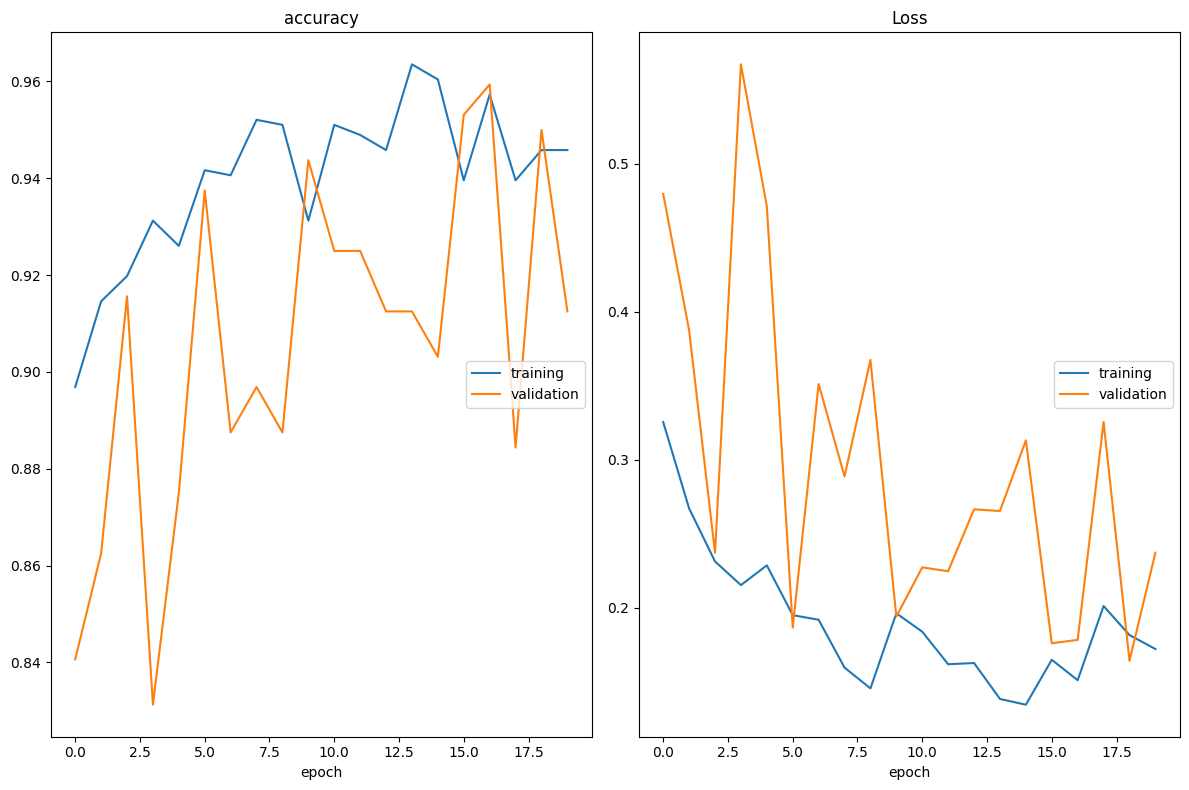

accuracy
	training         	 (min:    0.897, max:    0.964, cur:    0.946)
	validation       	 (min:    0.831, max:    0.959, cur:    0.913)
Loss
	training         	 (min:    0.134, max:    0.325, cur:    0.172)
	validation       	 (min:    0.164, max:    0.567, cur:    0.237)
30/30 [==============================] - 103s 3s/step - loss: 0.1720 - accuracy: 0.9458 - val_loss: 0.2371 - val_accuracy: 0.9125


In [130]:
steps_for_each_epoch = train_gen.samples // BATCH_SIZE
validation_steps_for_each_epoch = validation_gen.samples // BATCH_SIZE

OPTIMIZER = Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

## save model after every epoch ##
checkpointer = ModelCheckpoint(filepath='img_model.trained.weights.hdf5', verbose=1, save_best_only=True)

## Early stopping to stop over training
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

history = model.fit(
    train_gen, 
    epochs=EPOCHS, 
    steps_per_epoch=steps_for_each_epoch,
    validation_data=validation_gen,
    validation_steps=validation_steps_for_each_epoch,
    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
    verbose=True
)

In [ ]:
test_data_gen = ImageDataGenerator(rescale=1/255.)

testgen = test_data_gen.flow_from_directory(
    test_dir,
    target_size=INPUT_SHAPE,
    batch_size=1,
    class_mode=None,
    classes=classes,
    shuffle=False,
    seed=42
)

Found 400 images belonging to 4 classes.


In [ ]:
model.load_weights('img_model.trained.weights.hdf5')
predicted_classes = predictions = np.argmax(model.predict(testgen),axis=1)
class_indices = train_gen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

400/400 [==============================] - 15s 37ms/step


In [127]:
def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    
    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))
       

In [129]:
class_labels = ['0:Precision', '2:Recall', '3:F-Score','4Support']

results = display_results(true_classes, predicted_classes,class_labels);
print(results)

Overall Categorical Accuracy: 25.00%
             Precision  Recall  F-Score  Support
0:Precision       0.25     1.0      0.4    100.0
2:Recall          0.00     0.0      0.0    100.0
3:F-Score         0.00     0.0      0.0    100.0
4Support          0.00     0.0      0.0    100.0


c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


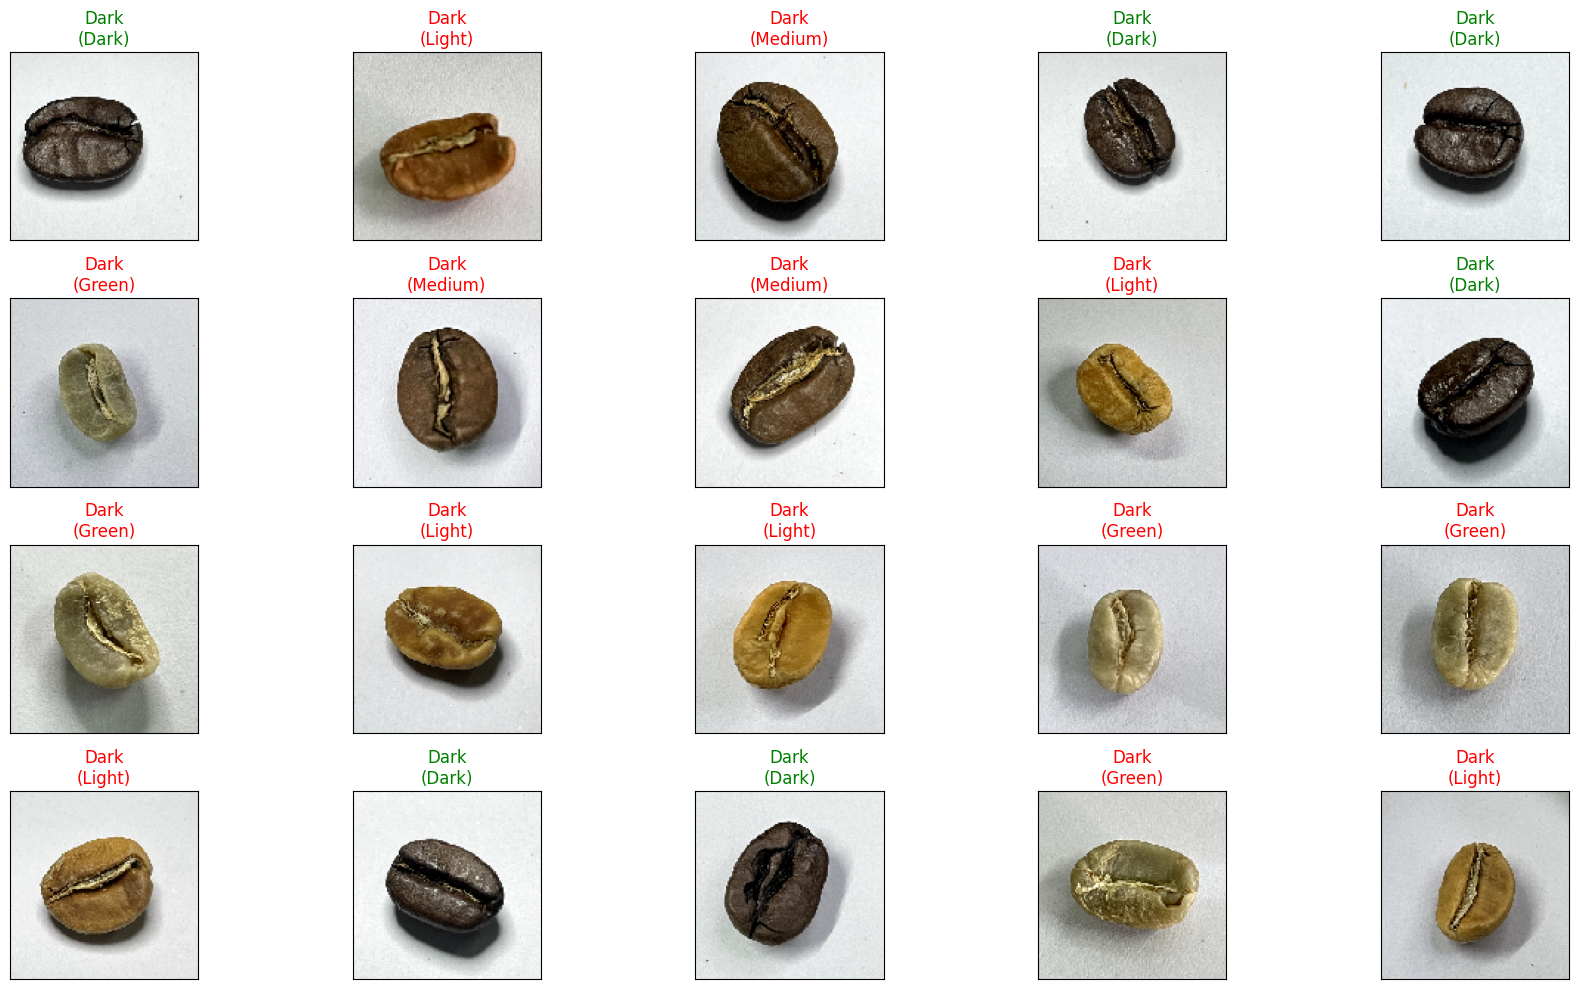

In [61]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

In [13]:
import tensorflow as tf

In [ ]:
model.load_weights('img_model.trained.weights.hdf5')

In [1]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

NameError: name 'tf' is not defined